# Human mobility from social view

In [12]:
# import dask.dataframe as dd
import pandas as pd
import feather as ft
%matplotlib inline
import numpy as np
# import pylab as pl
from pyitlib import discrete_random_variable as drv
from math import log, e
from scipy.stats import entropy

## Data pre-processing

In [13]:
""" Data pre-processing """
# df_full = dd.read_csv("data/weeplace_checkins.csv")
# # df_full = df_full.dropna(subset=["placeid"])
# df_full = pd.read_csv("data/weeplace_checkins.csv")
# # df_full = df_full.dropna(subset=["placeid"])
# # full dataset only removing NA location
df_full = ft.read_dataframe('data/weeplace_checkins_without_loc_NA.feather')

# make new dataframe removing minutes and seconds information, called df_hour
# df_full['datetime'] = dd.to_datetime(df_full['datetime']).dt.floor('H')
# df_full['datetime'] = pd.to_datetime(df_full['datetime']).dt.floor('H')
# ft.write_dataframe(df_full, 'data/weeplace_checkins_hour_without_loc_NA.feather')
# # full dataset removing NA location and group the time into 1-hour bin
df_hour = ft.read_dataframe('data/weeplace_checkins_hour_without_loc_NA.feather')

# # # for each userid, get the range of datetime
# df_time_range = df_hour.groupby('userid').agg({'datetime': ['max', 'min']}).datetime
# # create full hourly time (empty) slots in the range for each userid
# df_full_time = df_time_range.apply(lambda x: pd.date_range(x['min'], x['max'], freq = '1H', closed='right')[:-1], axis = 1)

# # create new dataframe with userid and full datatime-hourly
# l1 = []
# l2 = []
# for idx in df_full_time.index:
#     for itm in df_full_time[idx]:
#         l1.append(idx)
#         l2.append(itm)

# df_temp = pd.DataFrame()
# df_temp['userid'] = l1
# df_temp['datetime'] = l2

# ft.write_dataframe(df_temp, 'data/weeplace_checkins_hourly_full_time.feather')
# # df_temp = ft.read_dataframe('data/weeplace_checkins_hourly_full_time.feather')

# # join two dataframe, df_temp and df_hour
# df_hourly_datetime = df_temp.append(df_hour, ignore_index=True, sort=False)

# # remove duplicates, only use the first record if there are many records in one hour
# df_hourly_datetime.drop_duplicates(['datetime', 'userid'], keep='first', inplace=True)
# ft.write_dataframe(df_hourly_datetime, 'data/weeplace_checkins_hourly_datetime.feather')

In [ ]:
# # # full dataset removes NA location, group time into 1-hour bin, and add NA location for every 1-hour bin to fill in
# # # the gap between earliest checkin and latest check in time for each user.
# df_hourly_datetime = ft.read_dataframe('data/weeplace_checkins_hourly_datetime.feather')

## Co-occurance-based friendship construction

In [14]:
# print how many unique placeid in the dataset and how many unique userid in the dataset
print(len(df_hour['placeid'].unique()), len(df_hour['userid'].unique()))

971307 15793


In [172]:
username = df_hour['userid'].unique().tolist()
N_users = len(username)

# allocate space for object array
meetup_store = np.empty(N_users, dtype=object)

for id in username:
    ego = df_hour[df_hour['userid'] == id][['userid', 'placeid', 'datetime']]
    alter = df_hour[df_hour['userid']!=id][['userid', 'placeid', 'datetime']]
    
    meetup = ego.merge(alter, how='left', on =['placeid', 'datetime'])\
    .dropna()[['userid_x','placeid', 'userid_y']].groupby(['userid_x','userid_y'])['placeid']\
    .count().reset_index(name='count').sort_values('count', ascending=False)
    
    meetup[['percent']] = meetup[['count']]/meetup['count'].sum()
    meetup_store[username.index(id)]=meetup
#     print(len(meetup.dropna()[['userid_y']]['userid_y'].unique()))

import pickle

# save pickle file
pickle_out = open("meetup_store.pickle", "wb")
pickle.dump(meetup_store, pickle_out)
pickle_out.close()

In [168]:
del meetup_store
# read picle file
pickle_in = open("meetup_store.pickle", "rb")
meetup_store = pickle.load(pickle_in)

In [178]:
meetup_store[10020]

,userid_x,userid_y,count,percent
18,clyde-erwin-barretto,jeremiah-pommerville,3,0.069767
6,clyde-erwin-barretto,cindy-au,3,0.069767
2,clyde-erwin-barretto,andrew-mercando,2,0.046512
0,clyde-erwin-barretto,alexandra-k,1,0.023256
29,clyde-erwin-barretto,sean-bryan,1,0.023256
23,clyde-erwin-barretto,marq-romero,1,0.023256
24,clyde-erwin-barretto,michael-scott-hertzberg,1,0.023256
25,clyde-erwin-barretto,michael-shirley,1,0.023256
26,clyde-erwin-barretto,nicole-hering,1,0.023256
27,clyde-erwin-barretto,nikita-pavlov,1,0.023256


In [71]:
l = place_temp.tolist()
a = [[x,l.count(x)] for x in set(l)]

Counter(l)

df_place_temp = pd.DataFrame.from_dict(Counter(l), orient='index').reset_index()
df_place_temp.rename(columns={'index':'place', 0:'count'})

,place,count
0,funky-door-yoga-nob-hill-san-francisco,91
1,dosa-san-francisco,10
2,sunny-auto-body-san-francisco,1
3,taverna-aventine-san-francisco,1
4,bocadillos-san-francisco,1
5,stinson-beach-stinson-beach,1
6,w-san-francisco-san-francisco,2
7,oakland-international-airport-oak-oakland,1
8,jai-ho-indian-grocery-san-francisco,2
9,opinno-san-francisco-san-francisco,31


## Entropy computation

In [20]:
""" Different ways to estimate shannon entropy"""
def entropy1(labels, base=None):
    value,counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)

def entropy2(labels, base=None):
    """ Computes entropy of label distribution. """

    n_labels = len(labels)

    if n_labels <= 1:
        return 0

    value,counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0
    ent = 0.

    # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)
    
    return ent

import itertools
import functools
def entropy5(*X, base=None):
    base = 2 if base is None else base
    return sum(-p * log(p, base) if p > 0 else 0 for p in
        (np.mean(functools.reduce(np.logical_and, (predictions == c for predictions, c in zip(X, classes))))
            for classes in itertools.product(*[set(x) for x in X])))

In [34]:
""" Entropy computation time test"""
import time
start_time = time.time()
ent = entropy1(df_full.placeid.astype(str), base=2)
elapsed_time = time.time() - start_time
print(elapsed_time , '+' , ent)

start_time = time.time()
ent=entropy2(df_full.placeid.astype(str), base=2)
elapsed_time = time.time() - start_time
print(elapsed_time , '+' , ent)

# start_time = time.time()
# entropy5(df_full.placeid.astype(str), base=2)
# elapsed_time = time.time() - start_time
# print(elapsed_time , '+' , ent)

start_time = time.time()
ent = drv.entropy(df_full.placeid.astype(str), base=2)
elapsed_time = time.time() - start_time
print(elapsed_time , '+' , ent)

8.209025382995605 + 17.62318426311095
8.763607501983643 + 17.623184263080034
29.42532515525818 + 17.623184263110957


In [18]:
# user_shannon_ent = df_hour.set_index("userid")['placeid'].groupby(level=0).apply(lambda x: drv.entropy(x.astype(str), estimator='PERKS'))
user_shannon_ent = df_hour.set_index("userid")['placeid'].groupby(level=0).apply(lambda x: entropy2(x.astype(str), base=e))
user_shannon_ent

userid
00-a                 3.661417
0046aki              2.090259
01                   4.601427
0403                 4.233155
062                  2.072663
08                   4.821648
1-2-punch            3.744627
12                   2.399270
13                   1.331664
172                  2.474689
1od                  3.757096
26                   3.116755
29                   2.043321
3                    1.625467
30                   2.203194
31                   2.598799
337                  3.711427
3373                 2.147743
344                  2.661009
357                  0.760755
36_104k2             3.682681
38                   2.787876
4                    2.608614
4280                 1.822036
456                  3.245684
46                   2.474707
4sq-seoul            3.839385
4sq_test             0.000000
4sqchicago           2.540036
51                   1.332179
                       ...   
zinbythesea          3.588609
zirpoli-tiago        2.819470
ziv

In [247]:
# a = df_hourly_datetime[df_hourly_datetime['userid'] == '4sq_test']
drv.entropy(a.placeid.astype(str), estimator='PERKS')

array(0.8812909)

In [14]:
r_missing = df_hour.set_index("userid")['placeid'].notnull().groupby(level=0).agg(['mean', 'count'])

In [15]:
r_missing = r_missing.rename({'mean':'missing'}, axis = 1)
r_missing['missing'] = 1- r_missing['missing']

In [16]:
r_missing

,missing,count
userid,,
00-a,0,358
0046aki,0,126
01,0,508
0403,0,208
062,0,194
08,0,3557
1-2-punch,0,93
12,0,1075
13,0,14


pandas.core.frame.DataFrame

In [55]:
# To compute actual entropy
def contains(small, big):
    for i in range(len(big)-len(small)+1):
        if big[i:i+len(small)] == small:
            return True
    return False

def actual_entropy(l):
    n = len(l)
    sequence = [l[0]]
    sum_gamma = 0

    for i in range(1, n):
        for j in range(i+1, n+1):
            s = l[i:j]
            if contains(s, sequence) != True:
                sum_gamma += len(s)
                sequence.append(l[i])
                break

    ae = 1 / (sum_gamma / n ) * math.log(n)            
    return ae

In [26]:
# to compute predictability
import mpmath
N = 201
S = 5

def getPredictability(N, S):
    f = lambda x: (((1-x)/(N-1)) **(1-x))* x**x - 2**(-S)
    root = mpmath.findroot(f, 1)
    return float(root.real)

getPredictability(N, S)

0.47649529463319196

In [188]:
import seaborn as sns

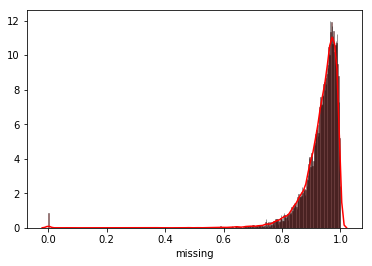

In [45]:
sns.distplot(r_missing['missing'], hist=True, kde=True, color = 'red', bins=500,
             hist_kws={'edgecolor':'black'})

In [43]:
r_missing[r_missing['missing'] <0.5]

,missing,count
userid,,
amy-clark1,0.000000,1
andre-roueiheb,0.000000,1
andrefir,0.000000,4
ben-congleton,0.000000,1
beth,0.000000,1
c-town-supermarket,0.333333,3
charlie-gakit7,0.000000,1
clomie,0.000000,1
dan-mckinney,0.000000,1


In [5]:
a = df_hourly_datetime.set_index('datetime')

In [7]:
a.placeid.unique()

array([None, 'jeffreys-grocery-and-luncheonette-new-york',
       'punch-new-york', ..., 'the-iron-motor', 'supersteil-rotterdam',
       'beukelsdijk-rotterdam'], dtype=object)

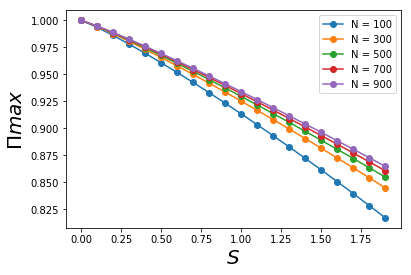

In [13]:
nlist  = np.arange(100, 1000, 200)
slist = np.arange(0, 2 ,0.1)
nsplist = []
for N in nlist:
    for S in slist:
        p = getPredictability(N, S)
        nsplist.append([N, S, p])

df = pd.DataFrame(nsplist, columns = ['N', 'S', 'P'])
groups = df.groupby('N')
for name, group in groups:
    pl.plot(group.S, group.P, label = "N = "+ str(name), marker='o', linestyle='-')
pl.legend()
pl.xlabel('$S$', fontsize = 20)
pl.ylabel('$\Pi{max}$ ', fontsize = 20)
pl.show()

In [39]:
-math.log((8 ** 4)/(9 ** 5))/9

0.2964840799957503

In [4]:
import pandas as pd
import scipy.stats
import numpy as np

In [42]:
def ent(data):
    """Calculates entropy of the passed `pd.Series`
    """
    p_data = data.value_counts()           # counts occurrence of each value
    entropy = scipy.stats.entropy(p_data/9)  # get entropy from counts
    return entropy

def entropy5(*X, base=None):
    base = 2 if base is None else base
    return sum(-p * log(p, base) if p > 0 else 0 for p in
        (np.mean(functools.reduce(np.logical_and, (predictions == c for predictions, c in zip(X, classes))))
            for classes in itertools.product(*[set(x) for x in X])))

In [31]:
a = [1,2,3]

In [34]:
b = [1,1,3]
c = zip(a,b)
c

In [35]:
entropy5(c)

0

In [45]:
2.1476/0.6931

3.098542778819795